# Flyouts
During a play, it is decided whether it will be a groundout, flyout, or hit. This notebook encompasses all baserunner advancement possibilities after a flyout has been decided.

So far, we can confirm that baserunner indulgence is positively correlated with advancing. The formulas are still unclear.


In [1192]:
# Load Dataframe

import glob

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-flyout.csv")

df = pd.concat((pd.read_csv(f, dtype={'roll': str}) for f in all_files), ignore_index=True)

# seasons = [11,12,13,14]
seasons = [11,12]
df = df[df['season'].isin(seasons) & df['stadium_id'].isna()]
df = df[df['roll'] != '[]'] # The unpacking code thinks empty is 1 roll, so exclude it here.

# Up to 2 rolls for flyouts, so split them up here
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
print(df[[len(rolls) == 2 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
print(df[[len(rolls) == 1 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
# print(np.count_nonzero([len(rolls) == 3 for rolls in df['roll'].to_list()]))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2',], index = df.index)
df[['roll1','roll2']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

print(f"{len(df)} events before filtering.")

baserunners  baserunners_next
[2, 0]       [0]                 136
             [1]                   7
[2, 1, 0]    [1, 0]               53
             [2, 0]               15
[2, 1]       [1]                  33
             [2]                  15
[2, 2]       [2]                   1
dtype: int64
baserunners  baserunners_next
[0]          [0]                 1599
             [1]                   92
[1, 0]       [1, 0]               240
             [2, 0]                57
[1]          [1]                  424
             [2]                  155
[2, 0]       [2, 0]                67
[2, 1, 0]    [2, 1, 0]             30
[2, 1]       [2, 1]                16
[2, 2]       [2, 2]                 2
[2]          [2]                  120
             []                   272
dtype: int64
3334 events before filtering.


In [1193]:
# Vibes

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0
df.loc[df["runner_on_second_mods"].astype(str).str.contains("SCATTERED"), "runner_on_second_vibes"] = 0
df.loc[df["runner_on_third_mods"].astype(str).str.contains("SCATTERED"), "runner_on_third_vibes"] = 0

df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
df['vibes_mul'] = 1 + 0.2*df['batter_vibes']
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()

for base in ["first","second","third","third_hh"]:
    for attr in [
        f"runner_on_{base}_base_thirst",
        f"runner_on_{base}_continuation",
        f"runner_on_{base}_ground_friction",
        f"runner_on_{base}_indulgence",
        f"runner_on_{base}_laserlikeness",
    ]:
        df[attr + "_scaled"] = df[attr] * df[f"runner_on_{base}_multiplier"]
        df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_on_{base}_vibes"])
df = df.copy()

for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df = df.copy()


for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_scaled"] = df[attr] * df["fielder_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["fielder_vibes"])
df = df.copy()

len(df)

3334

In [1194]:
# Ignore multipliers and some mods

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED"]:
    df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]

df = df[
    (df["pitcher_multiplier"] == 1)
    & (df["batter_multiplier"] == 1)
    & (df["fielder_multiplier"] == 1)
    & (df["runner_on_first_multiplier"] == 1)
    & (df["runner_on_second_multiplier"] == 1)
    & (df["runner_on_third_multiplier"] == 1)
    & (df["runner_on_third_hh_multiplier"] == 1)
]

print(len(df))

2141


# Begin Selection

In [1195]:
n_outliers = 0

## Runner on First

### [0] -> [0] (fail) or [1] (pass)
### [2, 0] -> [0] (fail) or [1] (pass)

1091
97
14       0.964668
16       0.650151
17       0.656783
48       0.218463
51       0.233449
           ...   
27862    0.124144
27864    0.303568
27865    0.690276
27866    0.489356
27890    0.554009
Name: roll_advance, Length: 1188, dtype: float64


,roll_log,runner_on_first_indulgence_with_vibe_log
14,-0.035972,-0.094988
16,-0.430550,-0.094988
17,-0.420402,-1.434137
48,-1.521141,-0.856431
51,-1.454790,0.220643
...,...,...
27862,-2.086315,-1.947502
27864,-1.192148,-1.947502
27865,-0.370664,-0.400734
27866,-0.714665,-0.400734


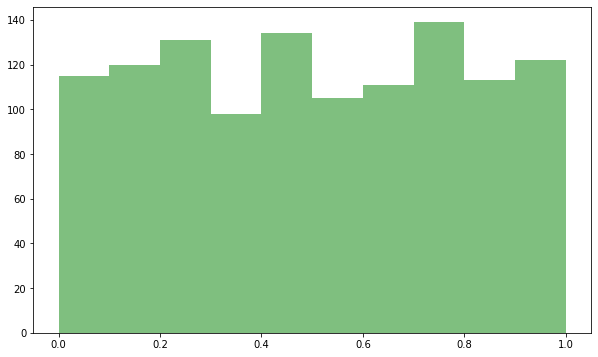

In [1196]:
print(len(df[(df['baserunners'] == "[0]") & (df['baserunners_next'].isin(["[1]","[0]"]))]))
print(len(df[(df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[1]","[0]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[0]") & (df['baserunners_next'].isin(["[1]","[0]"]))) \
    | \
    ((df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[1]","[0]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[0]") & (dfc['baserunners_next'].isin(["[1]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 0]") & (dfc['baserunners_next'].isin(["[1]"]))) \

# Make new roll field since some of these need roll1 and roll2
dfc['roll_advance'] = dfc['roll2']
dfc.loc[df['baserunners'].isin(["[0]"]), 'roll_advance'] = dfc.loc[df['baserunners'].isin(["[0]"]), 'roll1']
print(dfc['roll_advance'])

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll_advance'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
dfc['roll_log'] = dfc['roll_advance'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_log'] = dfc['runner_on_first_indulgence_with_vibe'].apply(math.log)
# dfc['runner_on_first_indulgence_with_vibe_pow'] = dfc['runner_on_first_indulgence_with_vibe']**3.5
dfc['runner_on_first_indulgence_with_vibe_pow'] = dfc['runner_on_first_indulgence_with_vibe']**4
X = dfc[
    [
        "roll_log",
        "passed",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_first_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
y = X["passed"]
X = X.drop("passed", axis=1)
X

In [1197]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[1125    3]
 [   1   59]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1128
        True       0.95      0.98      0.97        60

    accuracy                           1.00      1188
   macro avg       0.98      0.99      0.98      1188
weighted avg       1.00      1.00      1.00      1188

0.9966329966329966


In [1198]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[1.95535361]


[(-3.975169166220959, 'runner_on_first_indulgence_with_vibe_log'),
 (1.0, 'roll_log')]

[-1.95535361]
(-1.0, 'roll_log')
(3.975169166220959, 'runner_on_first_indulgence_with_vibe_log')


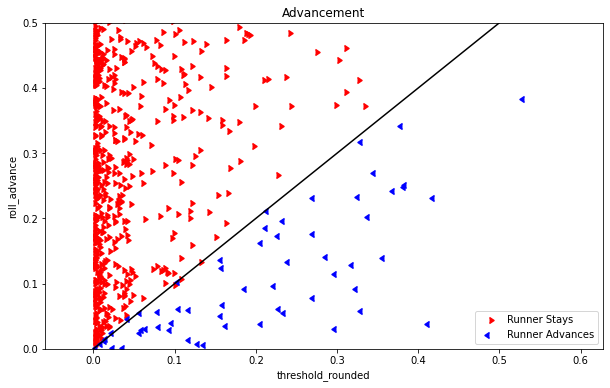

In [1199]:
# Make scatter plot

# Manual threshold
# dfc["threshold_rounded"] = 0 + 0.125 * dfc["runner_on_first_indulgence_with_vibe_pow"]
# dfc["threshold_rounded"] = dfc["runner_on_first_indulgence_with_vibe_pow"]/(math.exp(2))
# dfc["threshold_rounded"] = dfc["runner_on_first_indulgence_with_vibe"]**(3.975169166220959)/(math.exp(1.95535361))
dfc["threshold_rounded"] = dfc["runner_on_first_indulgence_with_vibe"]**(4)/(math.exp(2))
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll_advance":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll_advance"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll_advance"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll_advance")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


3 outliers


,passed,offset,roll_advance,threshold_rounded,event_type,inning,ballpark_mysticism,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,weather,season,day,game_id,play_count
10933,True,0.067793,0.635641,0.567848,flyout,5,0.5,Beck Whitney,NaN,LIFE_OF_PARTY;ELECTRIC,Fitzgerald Blackburn,NaN,Jordan Hildebert,FRIEND_OF_CROWS;SIPHON,NaN,Weather.BLACK_HOLE,12,59,71c9496b-b22e-4c76-8ff4-762e10f6ec3c,238
11163,True,0.000981,0.025056,0.024076,flyout,6,0.5,Oliver Mueller,NaN,NaN,Fish Summer,FIRE_EATER,Jenkins Good,ALTERNATE;FRIEND_OF_CROWS,EARLBIRDS,Weather.FLOODING,12,62,0d344bae-1406-4621-a342-e9f6dffc990f,225
26918,True,0.001092,0.045257,0.044165,flyout,2,0.5,Paula Mason,FIRE_EATER,FIREPROOF;SEALANT,Declan Suzanne,NaN,Wesley Poole,NaN,NaN,Weather.BLOODDRAIN,11,44,96f279b8-3962-4552-b1a8-2f235ca377f3,81


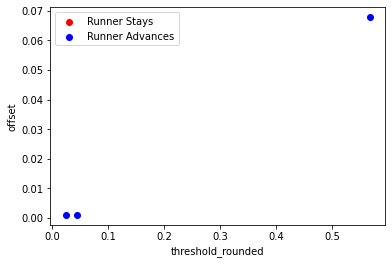

In [1200]:
# Plot outliers
dfc["offset"] = dfc["roll_advance"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll_advance",
        "threshold_rounded",
        "event_type",
        "inning",
        "ballpark_mysticism",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Runner on Second

### [1] -> [1] (fail) or [2] (pass)
### [1, 0] -> [1, 0] (fail) or [2, 0] (pass)
### [2, 1] -> [1] (fail) or [2] (pass)
### [2, 1, 0] -> [1, 0] (fail) or [2, 0] (pass)

383
180
30
49
7        0.193987
24       0.274255
57       0.117495
58       0.267742
96       0.465180
           ...   
27815    0.055993
27824    0.858661
27835    0.646840
27872    0.839264
27874    0.935373
Name: roll_advance, Length: 642, dtype: float64


,roll_log,runner_on_second_indulgence_with_vibe_log
7,-1.639962,0.218939
24,-1.293696,-0.748382
57,-2.141360,-4.584419
58,-1.317733,-0.650475
96,-0.765331,-0.403622
...,...,...
27815,-2.882534,-1.029457
27824,-0.152381,-0.295996
27835,-0.435656,-0.104061
27872,-0.175230,-0.094988


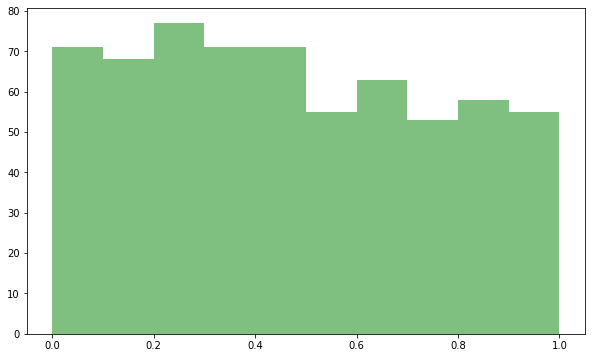

In [1201]:
print(len(df[(df['baserunners'] == "[1]") & (df['baserunners_next'].isin(["[2]","[1]"]))]))
print(len(df[(df['baserunners'] == "[1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))]))
print(len(df[(df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2]","[1]"]))]))
print(len(df[(df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[1]") & (df['baserunners_next'].isin(["[2]","[1]"]))) \
    | \
    ((df['baserunners'] == "[1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))) \
    | \
    ((df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2]","[1]"]))) \
    | \
    ((df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[1]") & (dfc['baserunners_next'].isin(["[2]"]))) \
                | \
                ((dfc['baserunners'] == "[1, 0]") & (dfc['baserunners_next'].isin(["[2, 0]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1]") & (dfc['baserunners_next'].isin(["[2]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1, 0]") & (dfc['baserunners_next'].isin(["[2, 0]"])))

# Make new roll field since some of these need roll1 and roll2
dfc['roll_advance'] = dfc['roll2']
dfc.loc[df['baserunners'].isin(["[1]","[1, 0]"]), 'roll_advance'] = dfc.loc[df['baserunners'].isin(["[1]","[1, 0]"]), 'roll1']
print(dfc['roll_advance'])

# dfc = df[df['baserunners'] == "[1]"]
# Define the final state runners as well
# dfc = dfc[dfc['baserunners_next'].isin(["[1]","[2]"])]
# print(len(dfc[~dfc['roll2'].isna()]))
# dfc["passed"] = dfc['baserunners_next'].str.contains("[2]")
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll_advance'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
# dfc['roll1'] = dfc['roll1'].apply(lambda x: x)
dfc['roll_log'] = dfc['roll_advance'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_log'] = dfc['runner_on_second_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_pow'] = dfc['runner_on_second_indulgence_with_vibe']**3.5
y = dfc["passed"]
X = dfc[
    [
        "roll_log",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_second_indulgence_with_vibe_log',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
X

In [1202]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[466  11]
 [ 12 153]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       477
        True       0.93      0.93      0.93       165

    accuracy                           0.96       642
   macro avg       0.95      0.95      0.95       642
weighted avg       0.96      0.96      0.96       642

0.9641744548286605


In [1203]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[0.97673002]


[(1.0, 'roll_log'),
 (-0.9715779562818213, 'runner_on_second_indulgence_with_vibe_log')]

[-0.97673002]
(0.9715779562818213, 'runner_on_second_indulgence_with_vibe_log')


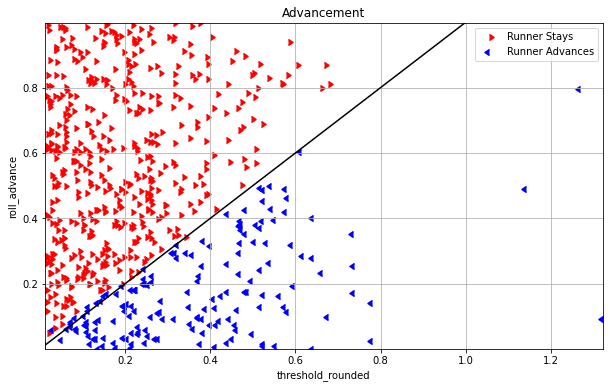

In [1204]:
# Make scatter plot

# Manual threshold
# dfc["threshold_rounded"] = 1.5*dfc["runner_on_second_indulgence_with_vibe_log"]
# dfc["threshold_rounded"] = dfc["runner_on_second_indulgence_with_vibe"]/math.exp(1)
dfc["threshold_rounded"] = ((dfc["runner_on_second_indulgence_with_vibe"] + 0.2)**2)/3.5
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll_log":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.scatter(
#     dfc[~dfc["passed"]][x_val],
#     dfc[~dfc["passed"]]["roll1"],
#     color="red",
#     label="Runner Stays",
#     marker=CARETRIGHTBASE,
# )
# ax.scatter(
#     dfc[dfc["passed"]][x_val],
#     dfc[dfc["passed"]]["roll1"],
    
#     color="blue",
#     label="Runner Advances",
#     marker=CARETLEFTBASE,
# )
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll_advance"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll_advance"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll_advance")
ax.set_title("Advancement")
ax.grid()
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")
ax.set_xlim(dfc["threshold_rounded"].min(),dfc["threshold_rounded"].max())
ax.set_ylim(dfc["roll_advance"].min(),dfc["roll_advance"].max())

ax.legend()


11 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count
3781,0.000299,True,0.012885,0.012585,flyout,1,NaN,NaN,NaN,Peanutiel Duffy,HONEY_ROASTED,Rivers Rosa,NaN,NaN,11,88,88682692-4615-4fe8-b7f9-042e59a74818,56
20737,0.001001,True,0.115937,0.114936,flyout,1,NaN,NaN,LATE_TO_PARTY,Axel Cardenas,NaN,Burke Gonzales,ALTERNATE,NaN,12,5,ed480597-01bc-419a-8d63-036f00ae792d,33
20745,0.002338,True,0.146681,0.144343,flyout,1,NaN,NaN,NaN,Vessalius Sundae,NaN,Ephraim Ladd,NaN,BOTTOM_DWELLER,12,5,ad383a96-f997-45d7-813e-8f034a15d04e,61
17388,0.003892,True,0.140793,0.136902,flyout,6,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,Lou Roseheart,TRIPLE_THREAT,Kennedy Rodgers,UNDEROVER,LATE_TO_PARTY,12,21,404f9425-5f3d-44ca-93ff-68c8f38e115a,248
14542,0.003956,True,0.077953,0.073998,flyout,7,Yusef Puddles,NaN,AFFINITY_FOR_CROWS,Lachlan Shelton,NaN,Mooney Doctor,NaN,EARLBIRDS,12,39,e663304a-8669-4ef6-bad3-7cb902fa0960,260
20804,0.006995,True,0.166835,0.159841,flyout,9,NaN,NaN,NaN,Swamuel Mora,NaN,Agan Harrison,NaN,LATE_TO_PARTY,12,5,ed480597-01bc-419a-8d63-036f00ae792d,310
4119,0.007600,True,0.081598,0.073998,flyout,2,NaN,NaN,AFFINITY_FOR_CROWS,Theo King,NaN,Parker Meng,ALTERNATE;PERK,LOVE;PARTY_TIME,11,93,2dfd21d7-81ec-498b-b16b-39c191f7635c,88
20702,0.009529,True,0.480062,0.151868,flyout,5,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,Baby Doyle,PERK,Campos Arias,ALTERNATE,EXTRA_STRIKE,12,4,d09c9c42-9749-4ae3-b4dd-2d231cb734c6,228
13911,0.010257,True,0.095214,0.084957,flyout,1,NaN,NaN,BOTTOM_DWELLER,Randy Dennis,SIPHON;SWIM_BLADDER,Sixpack Santiago,TRIPLE_THREAT,LIFE_OF_PARTY;ELECTRIC,12,32,1284296e-1cc3-4929-8933-11ac2a742334,76
26146,0.014271,True,0.129435,0.115164,flyout,2,NaN,NaN,AFFINITY_FOR_CROWS,Pudge Nakamoto,NaN,PolkaDot Zavala,NaN,NaN,11,33,56ee3bbe-aef9-4b46-a494-ba5d6d11f080,126


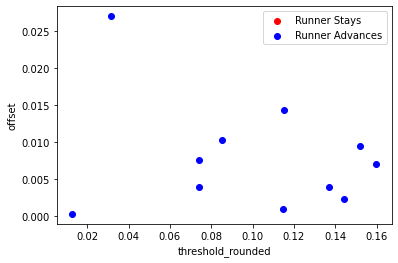

In [1205]:
# Outliers
dfc["offset"] = dfc["roll_advance"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Runner on Third

### [2] -> [2] (fail) or [] (pass)
### [2, 0] -> [2, 0] (fail) or [0] or [1] (pass)
### [2, 1] -> [2, 1] (fail) or [1] or [2] (pass)
### [2, 1, 0] -> [2, 1, 0] (fail) or [1, 0] or [2, 0] (pass)

233
69
42
141


,roll1,runner_on_third_indulgence_with_vibe
33,0.989935,1.407261
56,0.325904,1.112821
59,0.870317,0.703976
78,0.397576,0.399552
131,0.684485,0.731552
...,...,...
27773,0.371429,1.085418
27803,0.204793,0.571368
27812,0.048141,1.199163
27872,0.408737,0.728446


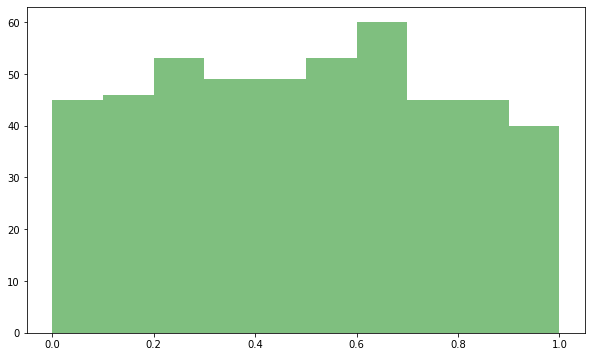

In [1206]:
# Bring in all situations with a runner on 3rd since the first roll is always to check if 3rd base advances
# print(df['baserunners'] == "[2]")
# print(df['baserunners_next'].isin(["[2]","[]"]))
# test = df['baserunners_next'].isin(["[]"])
print(len(df[(df['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[2]","[]"]))]))
print(len(df[(df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 1, 0]","[1, 0]","[2, 0]"]))]))
print(len(df[(df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2, 1]","[1]","[2]"]))]))
print(len(df[(df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[2, 0]","[0]","[1]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[2]","[]"]))) \
    | \
    ((df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 1, 0]","[1, 0]","[2, 0]"]))) \
    | \
    ((df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2, 1]","[1]","[2]"]))) \
    | \
    ((df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[2, 0]","[0]","[1]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[2]") & (dfc['baserunners_next'].isin(["[]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1, 0]") & (dfc['baserunners_next'].isin(["[1, 0]","[2, 0]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1]") & (dfc['baserunners_next'].isin(["[1]","[2]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 0]") & (dfc['baserunners_next'].isin(["[1]","[0]"])))

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
y = dfc["passed"]
X = dfc[
    [
        "roll1",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_base_thirst_with_vibe',
        # 'runner_on_first_laserlikeness_with_vibe',
        # 'runner_on_first_continuation_with_vibe',
        # 'runner_on_first_ground_friction_with_vibe',
        'runner_on_third_indulgence_with_vibe',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        # 'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        # 'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]-0.4*X["pitcher_shakespearianism_with_vibe"]
# X.drop("pitcher_shakespearianism_with_vibe", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]-0.1*X["fielder_tenaciousness_with_vibe"]
# X.drop("fielder_tenaciousness_with_vibe", axis="columns", inplace=True)
X

In [1207]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[146   0]
 [  0 339]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       146
        True       1.00      1.00      1.00       339

    accuracy                           1.00       485
   macro avg       1.00      1.00      1.00       485
weighted avg       1.00      1.00      1.00       485

1.0


In [1208]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.4582317]


[(1.0, 'roll1'), (-0.3341435412729013, 'runner_on_third_indulgence_with_vibe')]

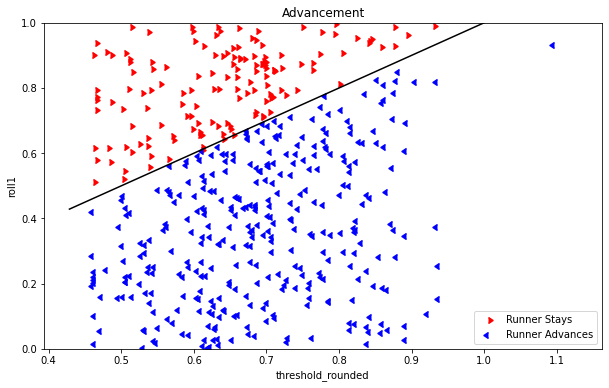

In [1209]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.46 + 1/3 * dfc["runner_on_third_indulgence_with_vibe"]
for thing in range(0,300,10):
    dfc.loc[dfc["threshold_rounded"].idxmax()]['threshold_rounded']

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


0 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


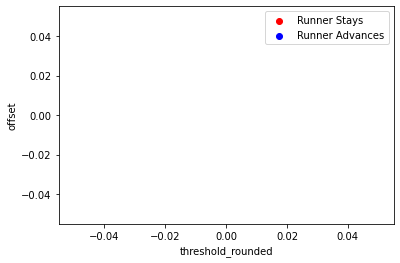

In [1210]:
# Outliers
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Runners Holding Hands on Third

### [2, 2] -> []
DP (unused), 3rd Advance (pass), 3rd hh Advance (pass)

In [1211]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) & (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

0


KeyError: 'roll3'

### [2, 2] -> [2]
DP (unused), 3rd Advance (fail), 3rd Advance hh (pass)
OR
DP (unused), 3rd Advance (pass), 3rd Advance hh (fail)
- We only have 3 examples of the former and none of the latter!

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] < dfc["threshold_advance_third"]) | (dfc["roll3"] < dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

### [2, 2] -> [2, 2]
DP (unused), 3rd Advance (fail), 3rd Advance (fail)

In [ ]:
# Define selection based on initial runners
# Baserunners are a string, not list, because pandas doesn't like lists.
dfc = df[df['baserunners'] == "[2, 2]"]
# Define the final state runners as well
dfc = dfc[dfc['baserunners_next'] == "[2, 2]"]
print(len(dfc))

# Make thresholds


dfc["threshold_advance_first"] = 0.50 + 0.35 * dfc["runner_on_first_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_second"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third"] = 0.50 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc["threshold_advance_third_hh"] = 0.50 + 0.35 * dfc["runner_on_third_hh_indulgence_with_vibe"] - 0.10 * dfc["fielder_tenaciousness_with_vibe"] - 0.10 * (dfc["ballpark_inconvenience"] - 0.50) - 0.10 * (dfc["ballpark_elongation"] - 0.50)
dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]] = dfc[["threshold_advance_first","threshold_advance_second","threshold_advance_third","threshold_advance_third_hh"]].clip(lower=0.001, axis="columns")

# Prove what we think is correct
dfc["guess"] = (dfc["roll2"] > dfc["threshold_advance_third"]) & (dfc["roll3"] > dfc["threshold_advance_third_hh"])
print(dfc["guess"].value_counts()) # If all True, we're right.

# Plot unused rolls
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

# Print Outliers
outliers = dfc[~dfc["guess"]]
n_outliers += len(outliers)
outliers[
    [
        "threshold_advance_second",
        "roll2",
        "event_type",
        "inning",
        "batter_name",
        "batter_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]